# Workshop #4. Statistical analysis of bulk RNA-seq

## Exercise

At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.

And feel free to ask questions! @daniilbobrovskiy

#### 1. Скачиваем данные и устанавливаем тулы

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz
!gunzip GSE110021_counts.Aug2015.txt.gz

In [ ]:
!echo "deb http://security.ubuntu.com/ubuntu focal-security main" | sudo tee /etc/apt/sources.list.d/focal-security.list
!apt-get update
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libssl1.1

!pip install --upgrade gdown
!gdown 1XAbJa_suP-WFTKK628oM9EWsV7k-6fI9
!gdown 1Bt4HDrZqFId_7Ph99pSvhfFHxyrV-kaL
!tar xf library.tar.gz

In [4]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("VennDiagram")'

** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (statmod)

The downloaded source packages are in
	‘/tmp/Rtmp5ZbqYf/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/VennDiagram_1.7.3.tar.gz'
Content type 'application/x-gzip' length 78508 bytes (76 KB)
downloaded 76 KB

* installing *source* package ‘VennDiagram’ ...
** package ‘VennDiagram’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded fro

In [5]:
%%R
suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(stringr)
  library(dplyr)
  library(DESeq2)
})

In [6]:
%%R
counts <- read.table("GSE110021_counts.Aug2015.txt")
counts <- data.frame(D1_cont_1=rowSums(select(counts, starts_with("D1.noTGFb.1"))),
                     D1_cont_2=rowSums(select(counts, starts_with("D1.noTGFb.2"))),
                     D1_cont_3=rowSums(select(counts, starts_with("D1.noTGFb.3"))),
                     D1_tgf_1=rowSums(select(counts, starts_with("D1.TGFb.1"))),
                     D1_tgf_2=rowSums(select(counts, starts_with("D1.TGFb.2"))),
                     D1_tgf_3=rowSums(select(counts, starts_with("D1.TGFb.3"))),
                     D20_cont_1=rowSums(select(counts, starts_with("D20.noTGFb.1"))),
                     D20_cont_2=rowSums(select(counts, starts_with("D20.noTGFb.2"))),
                     D20_cont_3=rowSums(select(counts, starts_with("D20.noTGFb.3"))),
                     D20_tgf_1=rowSums(select(counts, starts_with("D20.TGFb.1"))),
                     D20_tgf_2=rowSums(select(counts, starts_with("D20.TGFb.2"))),
                     D20_tgf_3=rowSums(select(counts, starts_with("D20.TGFb.3"))))

In [7]:
%%R
biomart <- read.table("biomart_hg19_ensembl75.tsv", sep="\t", header=TRUE)
protein_coding <- biomart$Gene.type[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)] == "protein_coding"
protein_coding[is.na(protein_coding)] <- FALSE
counts <- counts[protein_coding,]
ensembl <- biomart$Gene.stable.ID[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
symbol <- biomart$Gene.name[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]

#### 2. Анализ DESeq2
Шаги называются соответственно пайплайну edgeR

Let's use principal component analysis to visualize overall differences between our samples

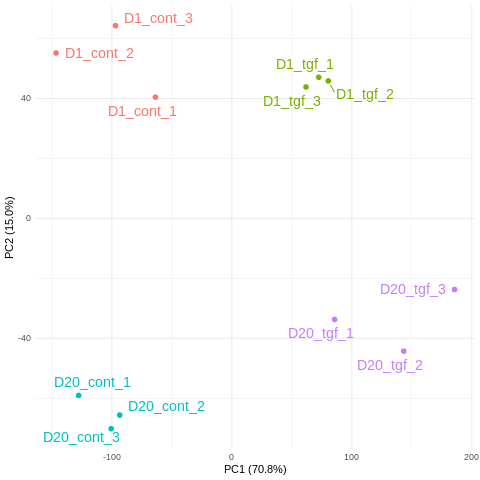

In [32]:
%%R
# Тут общий для обоих пайплайнов шаг – выделяем группы с помощью PCA
counts_scaled <- t(scale(counts))

pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

Loading our counts into DESeq2 and adding information about the groups

In [34]:
%%R
design <- model.matrix(~0+groups)
colnames(design) <- str_remove(colnames(design), "groups")
coldata <- data.frame(row.names=colnames(counts), group=groups)

dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = coldata,
                              design = design)
dds

class: DESeqDataSet 
dim: 19016 12 
metadata(1): version
assays(1): counts
rownames(19016): 79501 729759 ... 442868 9085
rowData names(0):
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(1): group


Filtering low-expressed genes

In [35]:
%%R
keep <- rowSums(counts(dds) >= 10) >= (0.25 * ncol(dds)) & rowSums(counts(dds)) >= 100
dds <- dds[keep, ]

In [ ]:
%%R
dds <- DESeq(dds)

In [47]:
%%R
dds$group

 [1] "D1_cont"  "D1_cont"  "D1_cont"  "D1_tgf"   "D1_tgf"   "D1_tgf"  
 [7] "D20_cont" "D20_cont" "D20_cont" "D20_tgf"  "D20_tgf"  "D20_tgf" 


In [48]:
%%R
res_cont_20vs1 <- results(dds, contrast=c(-1, 0, 1, 0))
res_tgf_20vs1 <- results(dds, contrast=c(0, -1, 0, 1))
res_d1_tgf <- results(dds, contrast=c(-1, 1, 0, 0))
res_d20_tgf <- results(dds, contrast=c(0, 0, -1, 1))

summary(res_cont_20vs1)
summary(res_tgf_20vs1)
summary(res_d1_tgf)
summary(res_d20_tgf)


out of 12381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3168, 26%
LFC < 0 (down)     : 3151, 25%
outliers [1]       : 2, 0.016%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3129, 25%
LFC < 0 (down)     : 3112, 25%
outliers [1]       : 2, 0.016%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1602, 13%
LFC < 0 (down)     : 1617, 13%
outliers [1]       : 2, 0.016%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 12381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2694, 22%
LF

Также, как в пайплайне edgeR – The smallest number of DE genes is found between the TGF-β-treated and untreated cells on day 1, which is expected.

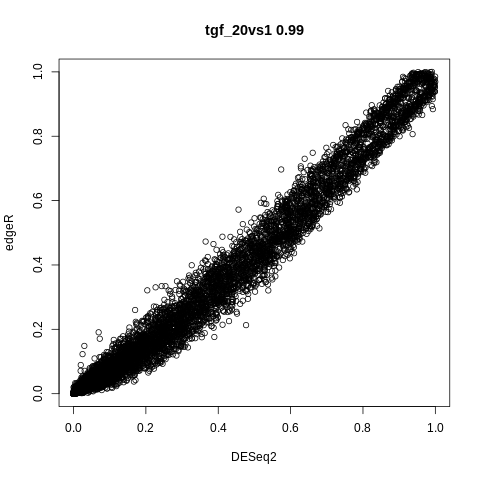

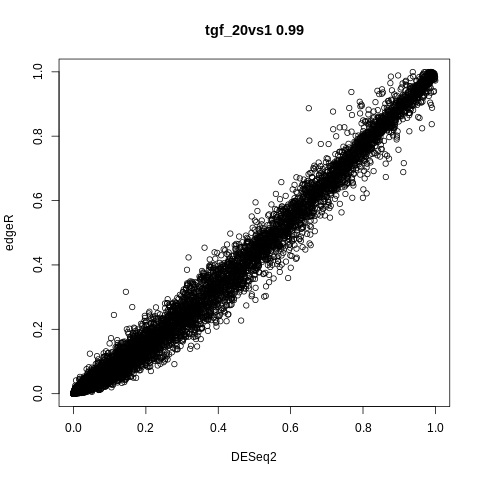

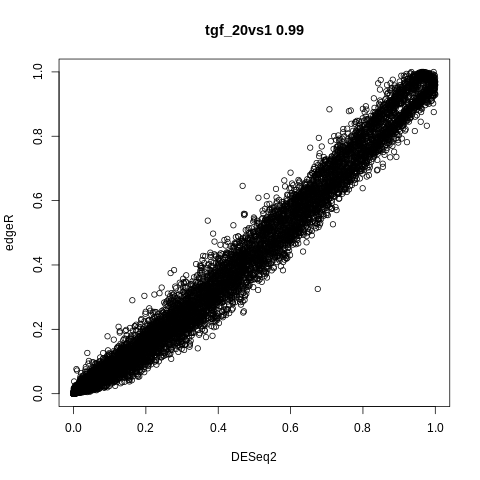

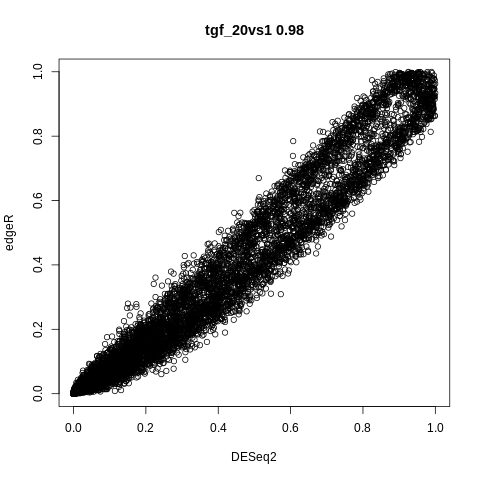

In [93]:
%%R
# qlf датафреймы для edgeR из ноутбука Дани

merged_df <- merge(as.data.frame(res_cont_20vs1), qlf_cont_20vs1$table, by = "row.names")
text <- paste0("tgf_20vs1, r=", as.character(round(cor(merged_df$pvalue, merged_df$PValue, use = "complete.obs"), 2)))
plot(
    merged_df$pvalue, merged_df$PValue,
     xlab = "DESeq2",
     ylab = "edgeR",
     main = text)

merged_df <- merge(as.data.frame(res_tgf_20vs1), qlf_tgf_20vs1$table, by = "row.names")
text <- paste0("tgf_20vs1, r=", as.character(round(cor(merged_df$pvalue, merged_df$PValue, use = "complete.obs"), 2)))
plot(
    merged_df$pvalue, merged_df$PValue,
     xlab = "DESeq2",
     ylab = "edgeR",
     main = text)

merged_df <- merge(as.data.frame(res_d1_tgf), qlf_d1_tgf$table, by = "row.names")
text <- paste0("tgf_20vs1, r=", as.character(round(cor(merged_df$pvalue, merged_df$PValue, use = "complete.obs"), 2)))
plot(
    merged_df$pvalue, merged_df$PValue,
     xlab = "DESeq2",
     ylab = "edgeR",
     main = text)

merged_df <- merge(as.data.frame(res_d20_tgf), qlf_d20_tgf$table, by = "row.names")
text <- paste0("tgf_20vs1, r=", as.character(round(cor(merged_df$pvalue, merged_df$PValue, use = "complete.obs"), 2)))
plot(
    merged_df$pvalue, merged_df$PValue,
     xlab = "DESeq2",
     ylab = "edgeR",
     main = text)

P-value между двумя подходами замечательно сходится!
Странно, что для группы tgf_20vs1 заметно меньше сходство, почему так – непонятно